# Bigram Model for Name Generation

Bigram is a primative character-level language model. Given a character it will predict the next character. It keeps track of the counts seen in the training dataset to create frequency distributions over the vocab given a previous character. These are normalised to give probability distributions i.e. given "a" what is the probability of the next character being "b". To generate new names we sample from a multinomial distribution (with probabilites given by the prob distribution of the previous character). The sample gives us the next character and we iterate untill we reach the start/end indicator token "."

## NN Linear Layer

We then compare this to the use of a Neural Network Linear layer. The idea being to train a linear layer using gradient based optimisation to "learn" the appropriate probability distributions over the vocab given a previous character, same as in the Bigram model but rather than counting the frequency of occurences of bigrams we will iteratively tune the weights of a Linear layer to, after activation, give us the prob dists.

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
#training data
names = open("names.txt", "r").read().splitlines()

#### Frequency Distributions of Next Character

In [6]:
#create a count of all bigrams (ordered pairs). 
bigram_counts_dict = {}

#pair characters in each name
for name in names:
    #add start end token
    chs = ["."] + list(name) + ["."]

    for ch1, ch2 in zip(chs, chs[1:]): # nice trick, name='emma' name[1:]='mma' (which is shorter). zip when reaches end stops!
       bigram_counts_dict[(ch1, ch2)] = bigram_counts_dict.get((ch1, ch2), 0) + 1

In [8]:
vocab = sorted(list(set(''.join(names)))) #concate all names together, throw dup, convert to list and sort
vocab.insert(0, ".") #insert our start and end indicator token at the start of our vocab

In [9]:
# create mappings from characters to idx and vice versa
char_to_idx = {char:idx for idx, char in enumerate(vocab)}
idx_to_char = {idx:char for idx, char in enumerate(vocab)}

In [10]:
#convert from bigram count dictionary to Tensor (to visualise as a matrix of shape (len(vocab), len(vocab))

bigram_tensor = torch.zeros([len(vocab), len(vocab)], dtype=torch.int32)

#iterate through each bigram pair and update that location in the tensor with the count
for (ch1, ch2), count in bigram_counts_dict.items():
    idx1, idx2 = char_to_idx[ch1], char_to_idx[ch2]
    bigram_tensor[idx1, idx2] = count

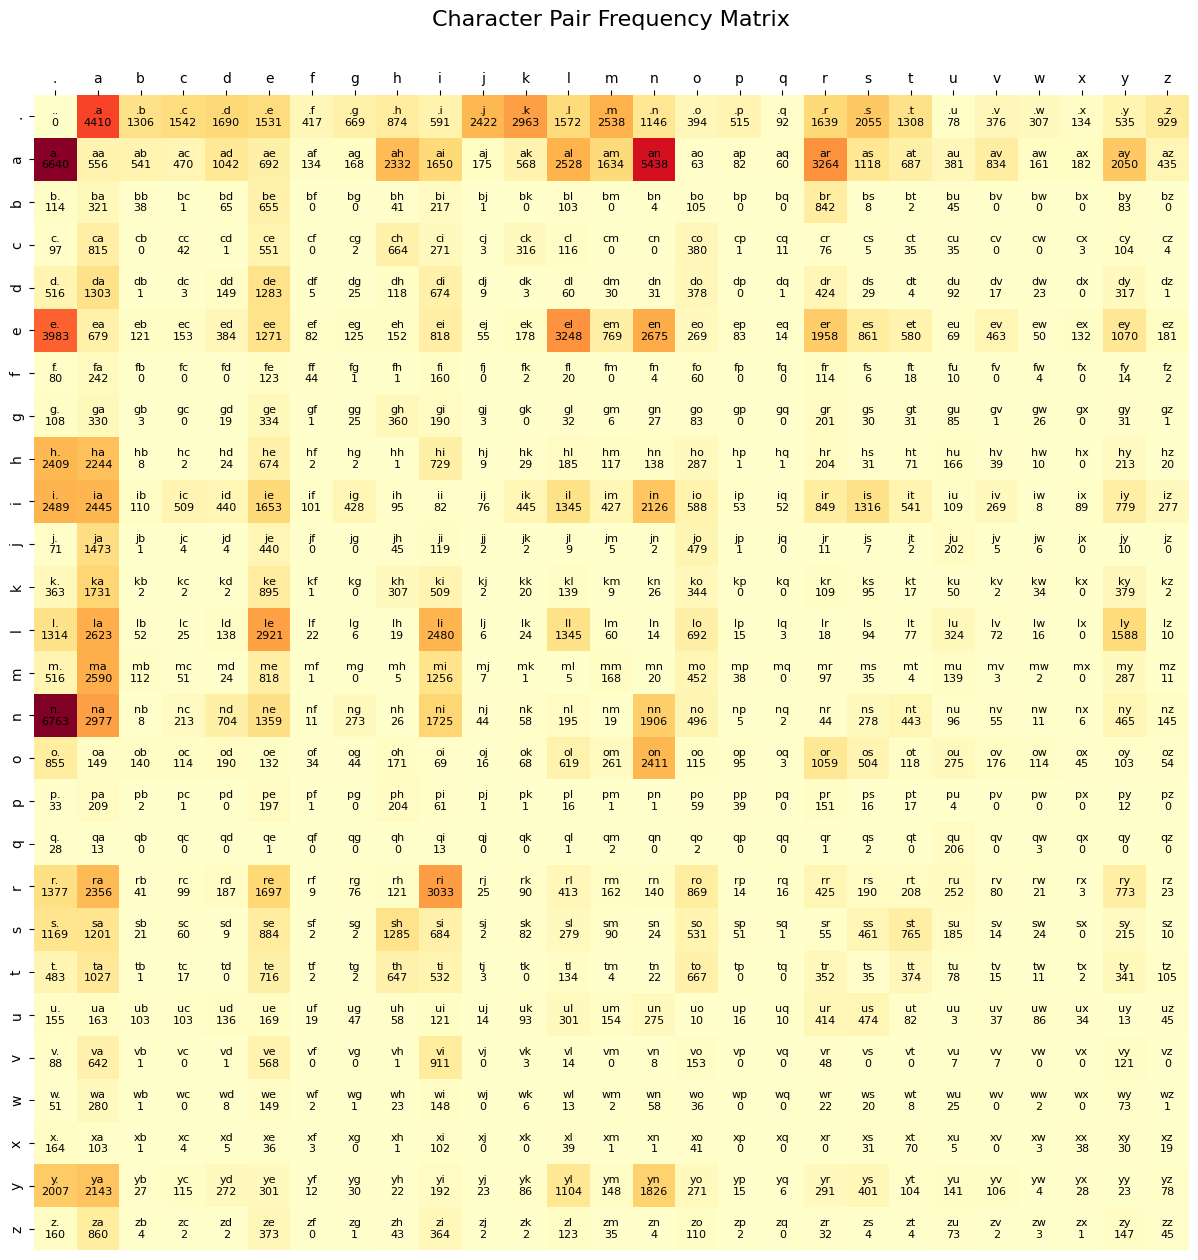

In [11]:
# visualise our counts
plt.figure(figsize=(15, 15))
ax = sns.heatmap(bigram_tensor, annot=False, cmap='YlOrRd', square=True, cbar=False, xticklabels=vocab, yticklabels=vocab)

# Add character pairs to each cell
for i in range(len(vocab)):
    for j in range(len(vocab)):
        plt.text(j + 0.5, i + 0.5, f"{vocab[i]}{vocab[j]}\n{bigram_tensor[i, j]}",
                 ha='center', va='center', fontsize=8)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.title("Character Pair Frequency Matrix", fontsize=16, pad=50)
plt.show()

Each row represents the frequency distribution of a character given a previous character. In order to produce new names we must convert these frequency distributions to probability distributions (easliy done by normalising over the counts) which we will then sample from. Since we are in a discrete setting (rather than continous) we can achieve the exact probability of a next character given a previous. Characters that have high probabilities are more likely to be sampled and thus make up the new name.

#### Probability Distributions of Next Character

In [29]:
# create probability dist by normalising each row by its sum
# `keepdim`` is cruitial here -> we want row sums so dont want to squeeze the column dim out. keep as a col vector
P = bigram_tensor.float() + 1 #include model smoothing (zero count give zero prob gives inf(log(likelihood)))
P /= bigram_tensor.sum(dim=1, keepdim=True) #inplace divison means no new memory is created! (More efficent)

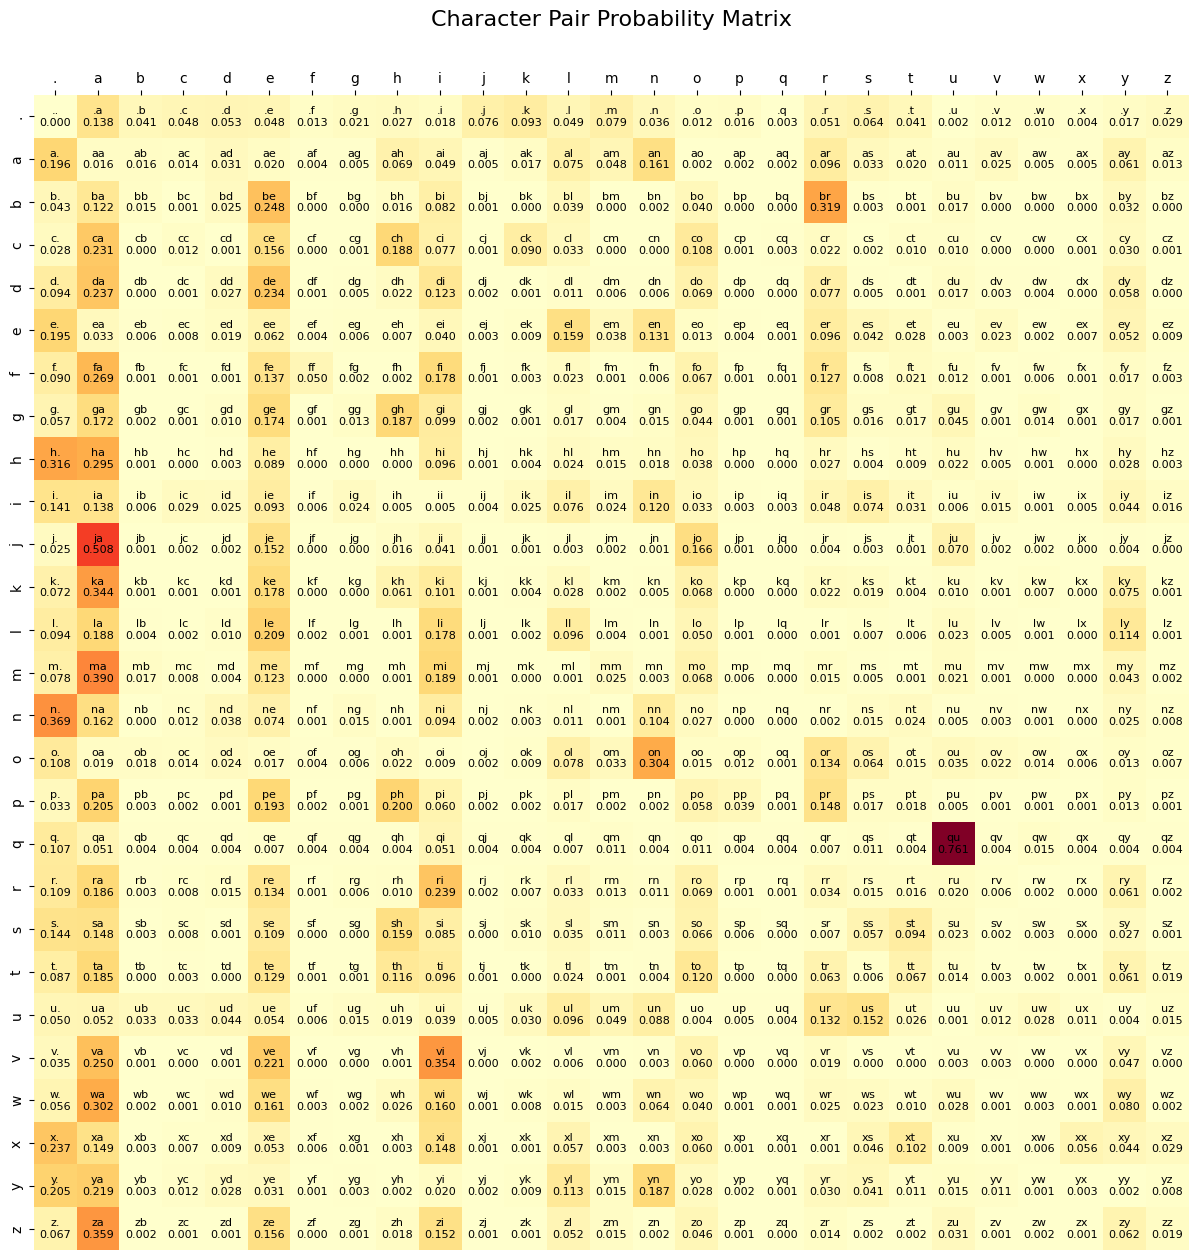

In [30]:
# visualise our probablities
plt.figure(figsize=(15, 15))
ax = sns.heatmap(P, annot=False, cmap='YlOrRd', square=True, cbar=False, xticklabels=vocab, yticklabels=vocab)

# Add character pairs to each cell
for i in range(len(vocab)):
    for j in range(len(vocab)):
        plt.text(j + 0.5, i + 0.5, f"{vocab[i]}{vocab[j]}\n{P[i, j]:.3f}",
                 ha='center', va='center', fontsize=8)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.title("Character Pair Probability Matrix", fontsize=16, pad=50)
plt.show()

Each row represnts the (discrete) probability distribution of the next character given a previous character. i.e. the 1st row represents the probability distribution of the 1st character of the name. "a" has a 13% probability of being the 1st letter in the name.

To generate new words we start with the 1st row (representing the 1st letter of a name since the previous charater is out start/end indicator character "."), we sample the probability distribution (to do this we send the probilities to a multinomial distibution, A multi-nomial distribution models the probabilities of multiple catagories in a single trial, returning the index of the catagory (character in our case)) which gives us the index of the next character. We then index that row  and draw again, untill we draw our start/stop indicator, signaling the end of the word.

The best way to visualise this sampling is as a 27 sided (len(vocab)) weighted dice. The dice is weighted according to the probabilities of next chara, so high prob gives high weighting and hence more likely to roll it. A trail/sample is a roll of this dice, where the dice lands gives the index of our vocab! 

#### Generate New Names

In [31]:
CREATE_NUM_NAMES=3

for i in range(CREATE_NUM_NAMES):
    ix=0 #start at 1st row (prob dist of next chara given the previous was the start/end indicator ".")
    word_store = ["."]

    while True:
        probs = P[ix] #select the prob dist associated with that char. idx=0 is prob dist where "." starts

        #sample the next character and store
        ix = torch.multinomial(probs, num_samples=1, replacement=True).item()
        word_store.append(idx_to_char[ix])

        #continue sampling until we reach our end character "."
        if ix == 0:
            break

    print("".join(word_store))

.sa.
.s.
.qundaherann.


#### Model Evaluation

The goal of our bigram model is to maximise the probabilities of the correct bigrams in our **training data**. We want to assign higher probabilities to the bigrams that actually appear in our training data and likewise assign lower probablities to those that dont appear that often or at all. Our bigram model is limited because it doesnt have the capapiblity to be iteratively trainined (they learn by estimating probabilities based on observed frequencies), but in future models such as transformers where we can train and thus learn longer and more complex patterns (hence assign better probabilites) having a performance metric is cruital not only for training the model (goal being to lower the loss) but to compare different model performances!

To measure performance, we measure how well the model assigns probabilities. A model is "good" if it assigns a higher probability to bigrams that are more likely to occur and likewise a "poor" model is one that doesnt (i.e. it assigns high probability to bigrams that dont occur often or at all or low prob to those that do)

In [27]:
P[0]

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

The bigram has learnt! If we assign equal probability to each character occuring given a previous character, we get 1/len(vocab) = 1/27 ~= 0.04 (or 4%). If we explore the Probability matrix we see that the probabilities differ! It has "learnt" (through counting the frequencies) to assign less probability to some chara and higher probability to others!

### How do we measure how "good" the model is?

Again the model is "good" if it assign high probability to bigrams that are likely to occur in our training data.

**Intuition behind Likelihood**

Think of likelihood as answering the question "How likely is it that our model would generate this exact sequence of characters?". It represents how well the model predicts the observed data. A good model will assign high probability to bigrams that actually occur in the language.

We are assuming **conditional independence a.k.a Markov Assumption** of events. Bigram models are based on the Markov assumption, specifically a first-order Markov model. This assumes that the probability of a character depends **only** on the previous character, not on any earlier history of characters.

NOTE: We need conditional independence rather than full independence because we need a way of preserving the sequential nature of characters. if we had true independence then P("matt") = P(m)P(a)P(t)P(t) = P(t)P(a)P(m)P(t)

e.g. Suppose we have the name "matt". The model breaks this into the bigrams ".m" "ma" "at" "tt" "t." The probability that our model predicts "matt" is:

P(".m" and "ma" and "at" and "tt" and "t.") = P(m|.)P(a|m)P(t|a)P(t|t)P(.|t) [since we are assuming conditional indpendence - which is correct since the probability of the current character depends only on the previous character (not any further history of characters) i.e. in our bigram model P(t|ma) = P(t|a) because our model doesnt consider anything other than the previous charaxter]

The likelihood is the **product** of the bigram probabilities. Our goal is to maxmise the likelihood, why? Well each probaility is between [0, 1]. A good model is a model where the highest probability is assigned to most likely next character. A (theoretically) prefect model would assign probability of one to the next character, i.e. it can predict with certainty. (theoretical, as this isnt possible consider the name "emma" well we have both "mm" and "ma", so a model cant assign probabiliy of one to each (due to the Axiom of prob must sum to 1)).


Maximisming likelihood 

`==>` maximising log(likelihood)

`==>` minimisng negative log(likelihood) 

`==>` minimising the average negative log(likelihood)

In [32]:
# likelihood is the product of bigram probabilities
# we want likelihood over our training set (which we can then use to compare to other models trained on the same data)
likelihood = torch.tensor(1.0)
log_likelihood = torch.tensor(0.0)
counter = 0

for name in names:
    name = ["."] + list(name) + ["."]
    for ch1, ch2 in zip(name, name[1:]):

        idx1, idx2 = char_to_idx[ch1], char_to_idx[ch2]
        bigram_prob = P[idx1, idx2]
        likelihood *= bigram_prob
        log_likelihood += torch.log(bigram_prob) #log(abc) = log(a) + log(b) + log(c)
        counter +=1


print("")
print(f"Likehood: {likelihood}")
print(f"log Likelihood: {log_likelihood}")
print(f"Negative Log Likeihood: {-log_likelihood}")
print(f"Average Negative Log Likelihood: {-log_likelihood/counter}")


Likehood: 0.0
log Likelihood: -559322.6875
Negative Log Likeihood: 559322.6875
Average Negative Log Likelihood: 2.4515998363494873


# Utalise a Neural Network to learn the "best" bigram probabilities for our Training Dataset

In the bigram model we counted the frequency of each bigram, normalised these over the row (i.e. over the array with the same starting characters) and ended-up with a probabilty distribution for the next character given the previous. We fed this prob dist into a `.multinomal()` which we could then sample from. The index from the multinomial represented the next predicted characters. names were iteratively built by continuted sampling based on previous character untill we drew the "." (start/end indicator) character.

Now we would like to build a Neural Network (NN) to "learn" the prob dist for a next character, given a previous character. (i.e. rather than counting the frequencies and establishing a prob dist). 1st step is to define our inputs and outputs, the fundamental advantage to NN is we decide what the inputs are and what we interprete the output as. Then with enough data the NN learns the right weight for our needs (we give it examples it predicts we define how wrong it is, it adjusts and trys again).

**INPUT**: 1-hot encoded vector, representing the index in our vocab of the 1st character (i.e. for bigram "em" its "e")

**OUPUT**: A vector of length 27 which represents the prob-dist of the 2nd character given the 1st character (input)

In [35]:
import torch.nn.functional as F

In [36]:
#transform data into inputs (1st char) and targets (predicted next char given the 1st char) 
xs, ys = [], []

for name in names:
    #add start end token
    chs = ["."] + list(name) + ["."]

    for ch1, ch2 in zip(chs, chs[1:]): #create bigrams .emma. ==> (., e), (e, m), (m, m), (m, a), (m, .) [5 examples in the word emma]
        # map character to index in vocab
        x, y = char_to_idx[ch1], char_to_idx[ch2]
        xs.append(x)
        ys.append(y)
xs = torch.tensor(xs) # for ".emma." xs=tensor([ 0,  5, 13, 13,  1])
ys = torch.tensor(ys) # for ".emma." ys=tensor([ 5, 13, 13,  1,  0])

#xs is one very long tensor of indicies of charaters in all the words in our training dataset
print(f"Number of bigrams: {xs.nelement()}")

#create one-hot encoding of xs and create randomised weights
#e.g for xs=tensor([ 0,  5, 13, 13,  1]) xenc has shape (5, 27)
xenc = F.one_hot(xs, num_classes=len(vocab)).float()
W = torch.randn((27,27), requires_grad=True) #tell torch that we'll want to compute the gradients and keep track of the comp graph

Number of bigrams: 228146


In [38]:
#gradient decent loop

number_of_iterations = 100

for i in range(number_of_iterations):

    ##################
    ## Forward pass ##
    ##################
    logits = xenc @ W #output of Linear layer which interprete as log(counts) (num_examples, len(vocab)) x (len(vocab), len(vocab)) gives (num_examples, len(vocab))
    counts = logits.exp() #exp to remove log in log(counts)
    prob_dists = counts / counts.sum(1, keepdim=True) #normalise to convert to prob dist. this is the softmax
    loss =  -prob_dists[torch.arange(ys.shape[0]), ys].log().mean() #average negative log likelihood

    ###################
    ## Backward pass ##
    ###################
    
    W.grad = None #initalise with zeros
    loss.backward() #conduct back prop - W.grad will now have gradients of loss w.r.t weights

    ###################
    ###### Update #####
    ###################
    #update the weights based on the gradient info
    W.data += -50 * W.grad # Can take large step in this case

    if i % 10 == 0:
        print(f"loss: {loss.item():.4f}")

loss: 3.8861
loss: 2.6748
loss: 2.5669
loss: 2.5270
loss: 2.5068
loss: 2.4947
loss: 2.4867
loss: 2.4812
loss: 2.4772
loss: 2.4742


Comparing this to our previous loss from the bigram counts... They are the same! (As expected). Why? Well if we look at what we are doing... we are multiplying xenc (which is a one-hot encoded vector) by our weights W. which picks out the ith row of W. that row is then exp (because we are dealing with "log-counts") and normalised to create a prob dist. Well this is what we were doing early with the counts. the counts matrix is taken, then normalised to give prob dist. So the weights is equvelent to the counts matrix, only difference is W is the log(counts)! So as we train we get closer and closer to the counts matrix! and then since we normalise and create prob dist, we will end up exactly the same!


Its incredible really. in the NN we randomly initalise the matrix and then let gradient of the loss guide us!

#### Generate New Names

We have now learnt the prob distributions. So to run inference we just take our 1st character (which is ".") one-hot encode, then send through (i.e. run the forward pass). That one-hot vector will essentially pick out the ith row in the weight matrix, which we send through softmax to give us our probability dist. Now we are in the same position as with the classic Bigram. We take prob dist for that next character that we just got from the network and send through  multinomail dist, sample and get next charcter. Repeat! i.e. take character, encode, pass through network, get prob dist, sample from multinomial, ... untill read end character again!

In [39]:
# Same as before (sample from multi nomial)

CREATE_NUM_NAMES=3

for i in range(CREATE_NUM_NAMES):
    ix=0
    out = []

    while True:
        ##BEFORE probs = P[ix] #select the prob dist associated with that char. idx=0 is prob dist where "." starts

        ##NOW
        xenc = F.one_hot(torch.tensor([ix]), num_classes=len(vocab)).float()
        logits = xenc @ W
        counts = logits.exp()
        prob_dist = counts / counts.sum(1, keepdim=True)
        
        ##SAME AS BEFORE
        #sample the next character and store
        ix = torch.multinomial(prob_dist, num_samples=1, replacement=True).item()
        out.append(idx_to_char[ix])

        #continue sampling untill characters untill we reach our end character "."
        if ix == 0: 
            break

    print("".join(out))

n.
dalacan.
jai.
